The CSV files with the training data can be downloaded in the following Kaggle challenge:
https://www.kaggle.com/c/facial-keypoints-detection

# Library and data importation

In [ ]:
import numpy  as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import missingno as msno
from keras.models import Sequential 
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import ZeroPadding2D
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import concatenate
from keras.constraints import maxnorm
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D, UpSampling2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.layers import ReLU
from keras.layers import Add

from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import Lambda

from keras.models import load_model
import tensorflow as tf

from keras.applications import ResNet50

from pathlib import Path

import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split

from keras.backend import tf as ktf

from keras.utils.vis_utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/PRDL-DL/training.csv /content/
!cp /content/drive/MyDrive/PRDL-DL/test.csv /content/

Mounted at /content/drive
cp: cannot stat '/content/drive/MyDrive/PRDL-DL/training2.csv': No such file or directory


Fix seed for replicability

In [ ]:
seed = 5
random_state= np.random.seed(seed)

As we are using a competition dataset, only the *training* dataset is labeled. Consequently, we will be treating *training* as our whole dataset.

In [ ]:
training = pd.read_csv('training.csv')

Let's discover the shape of the training and test set:

In [ ]:
print("Dataset shape is " +str(training.shape))

Dataset shape is (7049, 31)


# Data cleansing

The first task is to take care about the missing values, as the models are not able to handle samples with empty values. So, let's start watching the quantity of faulty data.

The next barchart, obtained using the library *missingno*, shows us that the quality of the dataset is not very good, as it contains a huge number of null values. 

It is clear that all images are at their place. It is eye-catching to see that every image contains the label of at least one keypoint for eyes, nose and mouth, however, the problem here is that more than the 60% of them lack more than one keypoint for each element of the face.


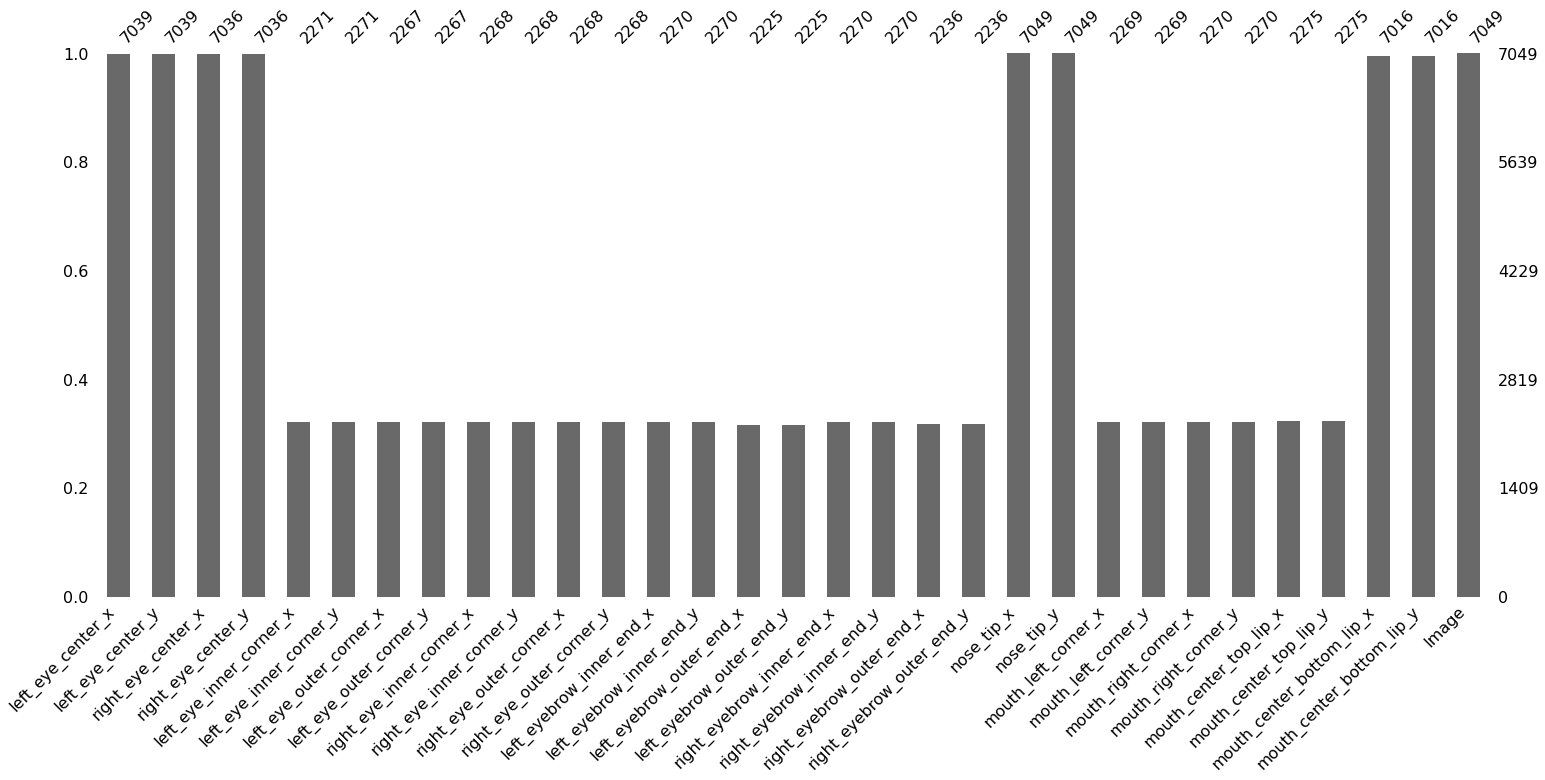

In [ ]:
msno.bar(training)

In [ ]:
nan_counts = training.isna().sum()
print(nan_counts)

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

Here we drop all the samples with lack of labels. We are going to work only with the images that are completely labelled.

In [ ]:
training = training.dropna()
training = training.reset_index(drop=True)

In [ ]:
print("Dataset shape is " +str(training.shape))

Dataset shape is (2140, 31)


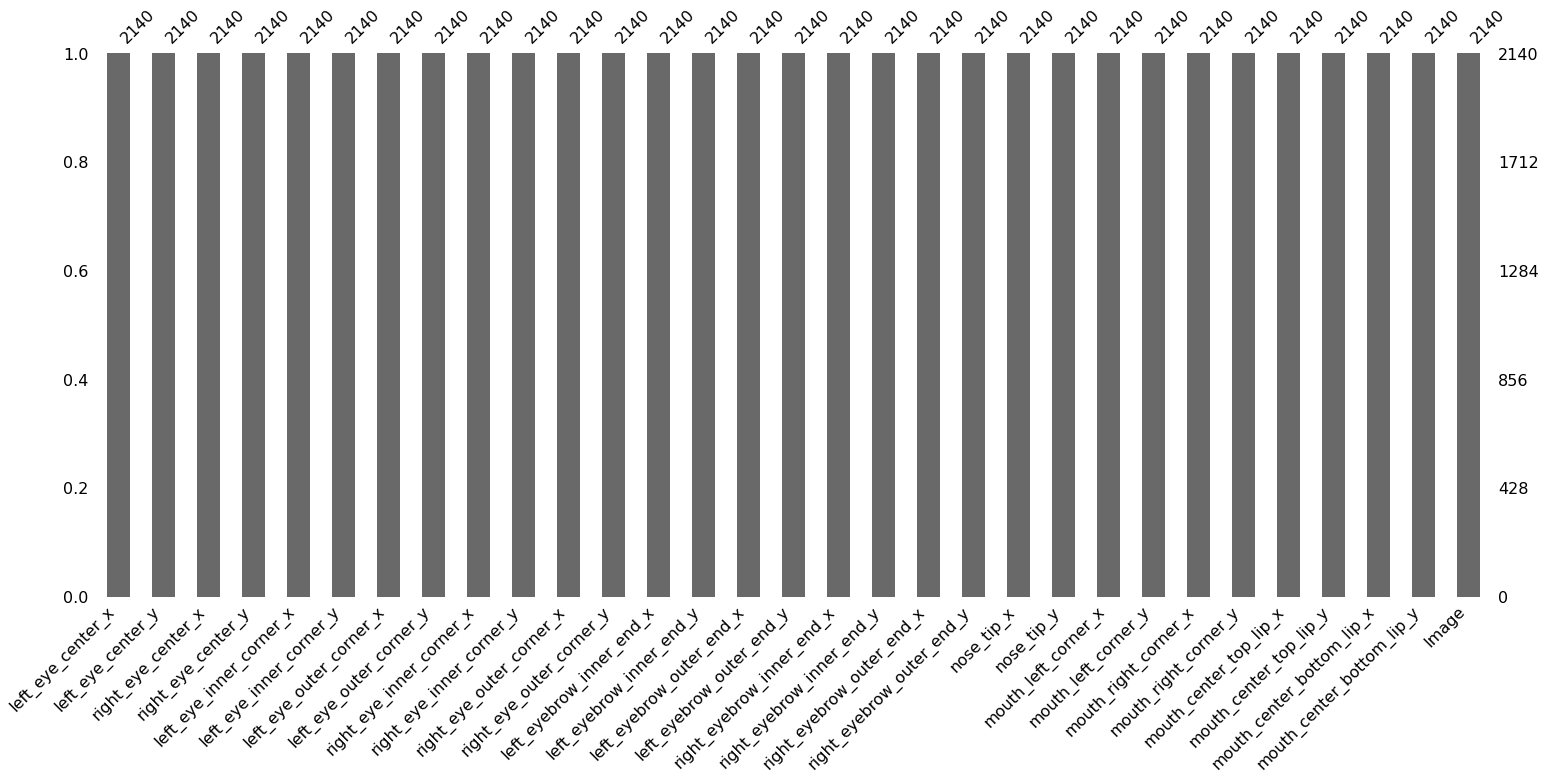

In [ ]:
msno.bar(training)

Here, the reshape of **all** images in the dataset into 96x96 is carried out.

In [ ]:
training_imgs = []
for i in range(len(training)):
  pixels = training["Image"][i].split(' ')
  img=np.reshape(np.array(pixels).flatten(), (96,96)).astype('int64')
  training_imgs.append(cv2.resize(img, (96,96)))

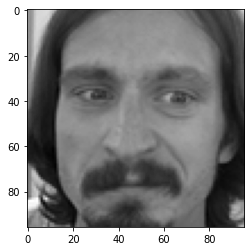

In [ ]:
plt.imshow(training_imgs[4], cmap='gray')

Next function will be useful for interpretation of the predictions made by the model, as it will make possible to visualize the keypoints on its corresponging image. 

In [ ]:
def image_with_kps(img, kps):
  plt.figure()
  plt.imshow(img, cmap='gray')
  for i in range(0, len(kps), 2):
    kp_coord = (np.int64(kps[i]), np.int64(kps[i+1]))
    
    plt.scatter(kp_coord[0], kp_coord[1], color="red")
    
  plt.show()

#Augmentation

Now, as the dataset does not contain a lot of images, we will do data augmentation BEFORE dividing the dataset into training and testing. It is CRITICAL to keep the original images and its augmentations in the same set to avoid data leakage, i.e., if an image is the testing/training set, all its augmented versions should be in the testing/training set and viceversa.

This code is an adaption of the one found in: 
https://towardsdatascience.com/facial-keypoints-detection-image-and-keypoints-augmentation-6c2ea824a59

The library *imgaug* is used.

The first augmentation will be focused in changing the quality and the illumination conditions within the image.

To augment images applying several transformations in a row, the *Sequential()* function is used.

To apply a determined transformation in not every image, *Sometimes()* is applied (e.g. in this case, for GaussianBlur). The 0.8 stated means that in the 80% of the cases, the transformation will be carried out.

*  **LinearContrast:** this changes the contrast of the image by scaling each pixel to 127+alpha*(v-127). In the formula *v* represents the value of the pixel and *alpha* is a multiplier to adjust the level of contrast change.

*  **GaussianBlur:**  blurs images using gaussian kernels. The images can be blurred from 0 to 3 at maximum, so in this case the upper limit is 2, as total blur is not wanted.






In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa

def gnoise_lincontrast(im_tr, pt_tr):
  seq = iaa.Sequential([iaa.LinearContrast((0.6, 1.5)), 
                        iaa.Sometimes(
        0.80, iaa.GaussianBlur(sigma=(0., 2.0)))])
  aug_ims = []
  aug_pts = []
  for im, pt in zip(im_tr, pt_tr):
    f_im = seq(image=im)
    # We keep both the original and the transformated images
    aug_ims.append(im)
    aug_ims.append(f_im)
    aug_pts.append(pt)
    aug_pts.append(pt)
  return np.asarray(aug_ims), np.asarray(aug_pts)


The past transformations did not require any keypoint change, but next one does.

The next transformation is **Affine transformation**. This involve: translation, rotation, scaling and shear.

For this project, only a rotation of maximum 15 degrees and a scaling of between 0.8 (zoom-out) and 1.2 (zoom-in).

As it is a geometric transformation, it involves the adequation of the keypoints to each change. To do that, *imgaug* transformation acts alongside *Keypoint* and *KeypointsOnImage* objects to ensure that they are correctly converted.

In [ ]:
from imgaug.augmentables import Keypoint, KeypointsOnImage

def rotate_aug(im_tr, pt_tr):
  seq = iaa.Sequential([iaa.Affine(rotate=15, scale=(0.8, 1.2))])
  aug_ims = []
  aug_pts = []
  coordlist = []
  
  for im, pt in zip(im_tr, pt_tr):
    #This loop saves first the original (x,y) coordinates for each keypoint
    xcoord = pt[0::2]
    ycoord = pt[1::2]
    for i in range(len(xcoord)):
      # Then, they are saved as an object of type Keypoint 
      coordlist.append(Keypoint(xcoord[i], ycoord[i]))
    #After this, the object KeypointsOnImage will store an object with shape of the image and with the original keypoints 
    kps = KeypointsOnImage(coordlist, shape=im.shape)
    #Then, the stablished Affine transformation will be applied to the image and the keypoints
    # f_im is the final image
    # f_kp is the set of final keypoints  
    f_im, f_kp = seq(image=im, keypoints=kps)
    all_coords = []
    # Finally, the transformed keypoints can be retreived
    for k in range(len(kps.keypoints)):
      before = kps.keypoints[k]
      after = f_kp.keypoints[k]
      all_coords.append(after.x)
      all_coords.append(after.y)
      all_coords_arr = np.asarray(all_coords)
    # We keep both the original and the transformated images
    aug_ims.append(im)
    aug_ims.append(f_im)
    aug_pts.append(pt)
    aug_pts.append(all_coords)
    coordlist.clear()
  return np.asarray(aug_ims), np.asarray(aug_pts)

Finally, the last transformation is the **horizontal flip** of the image

In [ ]:
def flip_im_points0(img, points): 
  flip_im = np.fliplr(img)
  xcoords = points[0::2]
  ycoords = points[1::2]
  new_points = []
  for i in range(len(xcoords)):
    xp = xcoords[i]
    yp = ycoords[i]
    new_points.append(96-xp)
    new_points.append(yp)
  return flip_im, np.asarray(new_points) 

def aug_flip0(im_tr, pt_tr):
  aug_ims = []
  aug_pts = []
  for im, pt in zip(im_tr, pt_tr):
    f_im, f_pts = flip_im_points0(im, pt)
    # We keep both the original and the transformated images
    aug_ims.append(im)
    aug_ims.append(f_im)
    aug_pts.append(pt)
    aug_pts.append(f_pts)
  return np.asarray(aug_ims), np.asarray(aug_pts)


Now, it is time to apply sequentially all transformations, bot for the training and validation sets.

Finally, after the augmentation, it is important to shuffle the images, so as the different variants of an image do not be fed to the model consecutively.

In [ ]:
from sklearn.utils import shuffle
# Define training set
labels = training.iloc[:,:-1]
training_imgs = np.array(training_imgs)



# Reserve 20% samples for validation
X_train, X_val, y_train, y_val = train_test_split(training_imgs, labels, test_size=0.2, random_state=random_state)


#Augment training set
X_train, aug_lab = gnoise_lincontrast(X_train, y_train.iloc)

X_train, aug_lab = rotate_aug(X_train, aug_lab)
X_train, aug_lab = aug_flip0(X_train, aug_lab)

X_train, y_train = shuffle(X_train, aug_lab)

#Augment test/validation set
X_val, aug_lab = gnoise_lincontrast(X_val, y_val.iloc)

X_val, aug_lab = rotate_aug(X_val, aug_lab)
X_val, aug_lab = aug_flip0(X_val, aug_lab)

X_val, y_val = shuffle(X_val, aug_lab)

X_train.shape

(13696, 96, 96)

After calling the augmentation function, let's try to visualize the augmented data to see if the labels were also correctly augmented.

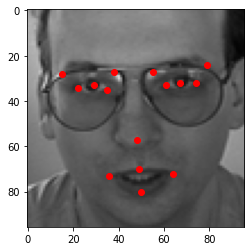

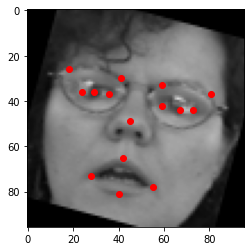

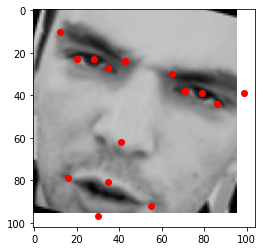

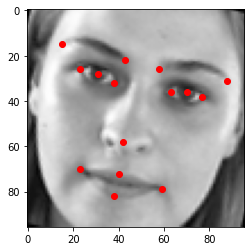

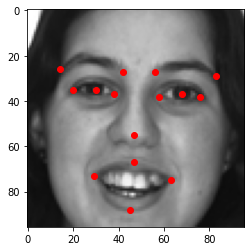

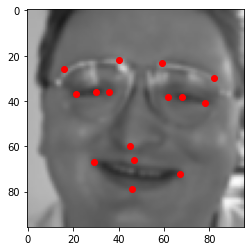

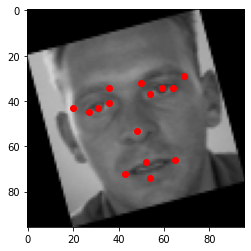

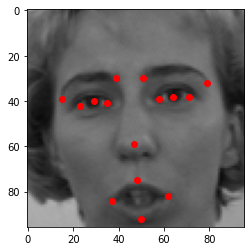

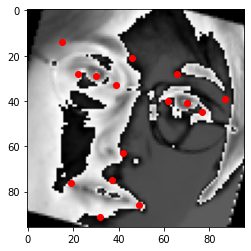

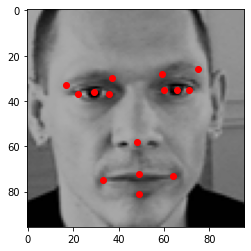

In [ ]:
lista=np.random.randint(0, len(X_train), size=5, dtype=int)

for i in lista:
  image_with_kps(cv2.cvtColor(np.uint8(X_train[i]), cv2.COLOR_GRAY2BGR), y_train[i])

lista=np.random.randint(0, len(X_val), size=5, dtype=int)
for i in lista:
  image_with_kps(cv2.cvtColor(np.uint8(X_val[i]), cv2.COLOR_GRAY2BGR), y_val[i])

# Training preparation

Normalize the data for faster convergence

This is not run for the Transformer architecture, as it employs non-normalized data.



In [ ]:
X_train = X_train/255.0
y_train = y_train/96.0
X_val = X_val/255.0
y_val = y_val/96.0

In [ ]:
image_height= training_imgs[0].shape[0]
image_width= training_imgs[0].shape[1]
image_channels= 1
output_dim = y_train.shape[1]


# Parameters that configures the training process
batch_size = 8 # Batch size
epochs = 3 # Number of epochs
initial_epoch = 0 # Initial epoch, it can be greater than 0 if you want to contiue a previous training process
initial_lr = 1e-3 # Learning rate
decay = 0

# Directory where to store weights of the model and results
experiment_rootdir = "./test/"
# Create experiment directory if it does not exists
if not os.path.exists(experiment_rootdir):
    os.makedirs(experiment_rootdir)

weights_path = "weights.h5" # Name of the file to store the weights

Here, we define a useful function, which will ease the training of the different models. It carries out:
* The compilation of the input model, stating Adam as the optimizer
* The training of the model storing it in a variable called *history* in order to make possible to retrieve metrics, loss function plots, etc.

In [ ]:
def train_model(X_train, y_train, X_val, y_val, model, initial_epoch, initial_lr, epochs):
    """
    Model training.

    # Arguments
       X_train, y_train: Training data.
       X_val, y_val: Validation data.
       model: A Model instance that is going to be compiled and trained.
       initial_epoch: Epoch from which training starts.
       epochs: number of epochs.
       initial_lr: learning rate.
       
    # Returns
        history: Model history
    
    """
    if weights_path == 'transfer.h5':
      model.build((None,image_height, image_width, 3))
    
    # Configure the trainig process by compiling the model. Select the loss fucntion, the optimizer, and the metric used to obtain results.
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), 
    loss=tf.keras.losses.MeanSquaredError())
    print(model.summary())
      
    
    
    # Fit the model by using the fit generator
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)
    #history = model.fit_generator(train_data_generator, validation_data=val_data_generator, epochs=epochs)
    # Return the history of the model to plot the loss and accuracy evolution
    return history

# VGG16

It is made up of five stacked convolutional blocks. Each convolutional block starts with two or three convolutional layers that are responsible to find patterns on data, with a high number of very small 3x3 filters with a stride of one. The number of filters increase as the blocks deepen, until reaching 512. This condition allows to perform a detailed study of the patterns within the input.

Finally it is connected to 3 FCs that will help to make the final prediction.

The VGG16 architecture is developed as following.

In [ ]:
 # VGG16 architecture
dropout=0.5
input_image = Input(shape=(image_height, image_width, image_channels))
x1 = Conv2D(64, (3, 3),padding='same', activation='relu')(input_image)
x1 = Conv2D(64, (3, 3),padding='same', activation='relu')(x1)
x1 = MaxPooling2D((2, 2))(x1)

x1 = Conv2D(128, (3, 3),padding='same', activation='relu')(x1)
x1 = Conv2D(128, (3, 3),padding='same', activation='relu')(x1)
x1 = MaxPooling2D((2, 2))(x1)

x1 = Conv2D(256, (3, 3),padding='same', activation='relu')(x1)
x1 = Conv2D(256, (3, 3),padding='same', activation='relu')(x1)
x1 = Conv2D(256, (1, 1),padding='same', activation='relu')(x1)
x1 = MaxPooling2D((2, 2))(x1)

x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
x1 = Conv2D(512, (1, 1),padding='same', activation='relu')(x1)
x1 = MaxPooling2D((2, 2))(x1)

x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
x1 = Conv2D(512, (1, 1),padding='same', activation='relu')(x1)
x1 = MaxPooling2D((2, 2))(x1)

x1 = Flatten()(x1)
x=Dense(4096, activation='relu', kernel_constraint=maxnorm(3))(x1)
x=Dropout(dropout)(x)

x=Dense(4096, activation='relu', kernel_constraint=maxnorm(3))(x)
x=Dropout(dropout)(x)

out= Dense(output_dim)(x1)

model = Model(inputs = input_image, outputs = out);

Here, run only the desired model. A switch case function has not been used due to its higher use of RAM, which made impossible to use the free version of Colab

In [ ]:
# Create the model by using the getModel function
weights_path = 'vgg16.h5'
# Train the model by using the trainModel function
history = train_model(X_train, y_train, X_val, y_val, model, initial_epoch, initial_lr, epochs)
# Save weights that can be used in future training process
weights_save_path = os.path.join(experiment_rootdir, weights_path)
model.save_weights(weights_save_path)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 96, 96, 64)        640       
                                                                 
 conv2d_27 (Conv2D)          (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 48, 48, 128)       73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 48, 48, 128)       147584    
                                                           

# Resnet: Skip Connections

In this section we are gonna perform a simple test to see the importance of skip connections. Resnet34 is a very deep neural network (34 layers) that was introduced as the first network using residual connections. An enhanced and deeper version of it now widely used, Resnet50, is the architecture that we are going to try. **To adapt the network for a regression problem, we are adding a dense layer at the end of the architecture preceded by a Global Average Pooling (GAP) layer**.

## Classical Resnet

In [ ]:
resnet_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(image_height, image_width, image_channels),
    pooling=None,
    classes=output_dim,
    
)

model = Sequential()
model.add(resnet_model)

model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(output_dim, activation = 'linear'))



In [ ]:
# Create the model by using the getModel function
weights_path = 'resnet50.h5'
# Train the model by using the trainModel function
history = train_model(X_train, y_train, X_val, y_val, model, initial_epoch, initial_lr, epochs)
# Save weights that can be used in future training process
weights_save_path = os.path.join(experiment_rootdir, weights_path)
model.save_weights(weights_save_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23581440  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 30)                61470     
                                                                 
Total params: 23,642,910
Trainable params: 23,589,790
Non-trainable params: 53,120
_________________________________________________________________
None
Epoch 1/30
428/428 [==============================] - 54s 94ms/step - loss: 0.1210 - val_loss: 0.018

## Plain Resnet (no skip connections)

As far as we are concerned, Keras does not a simple way to use Resnet50 without skip connections. Thus, we have modified the Resnet implementation provided in https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py to use a version with no residual connections.

In [ ]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    #x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    filters1, filters2, filters3 = filters
    
    bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)



    x = Activation('relu')(x)
    return x



bn_axis = 1

x = ZeroPadding2D(padding=(3, 3), name='conv1_pad')(input_image)
x = Conv2D(64, (7, 7),
                  strides=(2, 2),
                  padding='valid',
                  kernel_initializer='he_normal',
                  name='conv1')(x)
x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

x = GlobalAveragePooling2D()(x)

x = Flatten()(x)

outputs = Dense(output_dim, activation = 'linear')(x)

model = Model(input_image, outputs)

In [ ]:
# Create the model by using the getModel function
weights_path = 'net50.h5'
# Train the model by using the trainModel function
history = train_model(X_train, y_train, X_val, y_val, model, initial_epoch, initial_lr, epochs)
# Save weights that can be used in future training process
weights_save_path = os.path.join(experiment_rootdir, weights_path)
model.save_weights(weights_save_path)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 102, 102, 1)       0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 64)        3200      
                                                                 
 bn_conv1 (BatchNormalizatio  (None, 48, 48, 64)       192       
 n)                                                              
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 pool1_pad (ZeroPadding2D)   (None, 50, 50, 64)        0         
                                                             

# Resnet: Transfer Learning

Now, we are going to keep using Resnet50 to check if the performance is increased with some basic transfer learning. We are going to used the trained version of Resnet50 using ImageNet, a huge dataset with more than 14,000,000 annotated images. To try to do a fair comparison between this model and the previous ones, (to really see the impact of transfer learning), the architecture will be the same.

If you want to train the model with Resnet frozen, uncomment the marked line.

In [ ]:
resnet_model = tf.keras.applications.resnet50.ResNet50(
          include_top=False,
          weights='imagenet',
          input_tensor=None,
          input_shape=(224, 224, 3),
          pooling=None,
          classes=1000,
          
      )


model = Sequential()

model.add(Lambda(lambda image: ktf.image.resize(image, (224, 224))))

model.add(resnet_model)

model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(output_dim, activation = 'linear'))

# Uncomment the line below if we want to freeze the resnet50

#model.layers[1].trainable = False 


94765736/94765736 [==============================] - 7s 0us/step


ImageNet uses RGB images, thus, our grayscale images must be transformed to a fake RGB by repeating the same image 3 times.

In [ ]:
X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, -1)
X_val_rgb = np.repeat(X_val[..., np.newaxis], 3, -1)

In [ ]:
# Create the model by using the getModel function
weights_path = 'transfer.h5'
# Train the model by using the trainModel function

history = train_model(X_train_rgb, y_train, X_val_rgb, y_val, model, initial_epoch, initial_lr, epochs)
# Save weights that can be used in future training process
weights_save_path = os.path.join(experiment_rootdir, weights_path)
model.save_weights(weights_save_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 30)                61470     
                                                                 
Total params: 23,649,182
Trainable params: 23,596,062
Non-trainable params: 53,120
_______________________________________

# Autoencoder

Hourglass architecture has been initially designed for human pose estimation, which can be considered as a similar field of study. Note that Hourglass architecture allows stacking, i.e., Hourglass modules can be repeated sequentially multiple times. However, we are going to use a smaller architecture. Hourglass uses skip connections, although, we have seen that for our narrow architecture this can worsen the performance. Thus, no skip connections will be used.

In [ ]:
# First half of the hourglass

x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_image)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)

# Bottleneck layer
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)

# Second half of the hourglass
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)

#x = Add()([input_image, x])

# Output layer
x = Flatten()(x)

outputs = Dense(output_dim, activation = 'linear')(x)

model = Model(input_image, outputs)

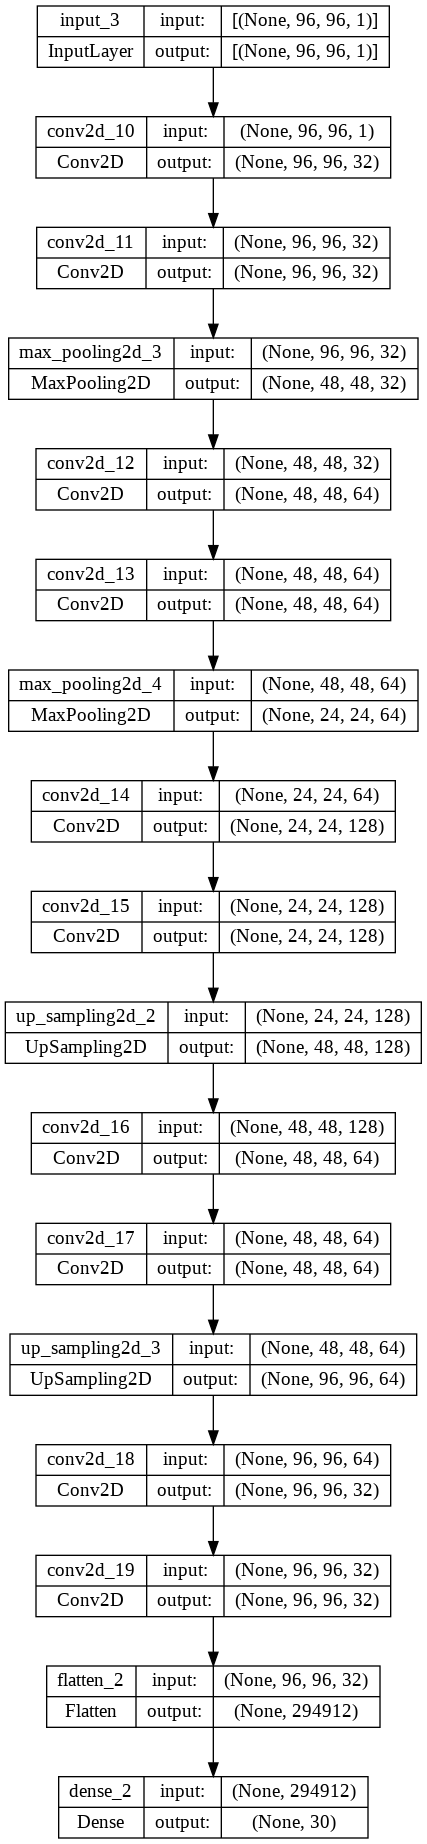

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Create the model by using the getModel function
weights_path = 'hourglass.h5'
# Train the model by using the trainModel function
history = train_model(X_train, y_train, X_val, y_val, model, initial_epoch, initial_lr, epochs)
# Save weights that can be used in future training process
weights_save_path = os.path.join(experiment_rootdir, weights_path)
model.save_weights(weights_save_path)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 64)        36928     
                                                             

# Transformers

Installing the necessary dependencies to build Transformers using Keras 

In [ ]:
pip install -U tensorflow-addons

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow as tf
import scipy.io
import shutil

Transformers traditionally undertake tasks that involve sequences of data, specially text, introducing as many inputs (words, in that case). So, to adapt transformers to the vision tasks, the first operation to do is obtaining a sequence of data given an image. But... how? The most used choice is to divide the image in many subimages, i.e. patches. This will allow to introduce different pieces of the global data into the transformer, achieving the attention purpose. This means the model will study each different patch, and will make a prediction taking into account not only the last tiles, but all of them, assigning different weights to each one according to its relevance.

This code is an adaption from the one found in *Keras* documentation available in:
https://keras.io/examples/vision/object_detection_using_vision_transformer/

In first place, the function to divide the image into several patches of size *patch_size* is created.
The *patch_size* has been selected as 24 in order to get a 4x4 (96/24=4) structure of tiles in the image, resulting in 16 patches per frame.

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    #Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        # This is the function which extracts the patches from the original images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

Here, we present a graphical example showing how the division of the image looks like.

Image size: 96 X 96
Patch size: 24 X 24
16 patches per image 
576 elements per patch


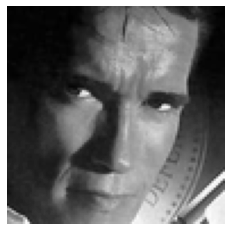

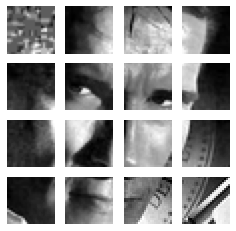

In [ ]:
patch_size = 24  # Size of the patches to be extracted from the input images
X_train_transf = np.expand_dims(X_train, axis=-1)
plt.figure(figsize=(4, 4))
plt.imshow(np.reshape(X_train[2], (96,96)).astype("uint8"), cmap='gray')
plt.axis("off")

patches = Patches(patch_size)(tf.convert_to_tensor([X_train_transf[2]]))
print(f"Image size: {image_height} X {image_width}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size))
    plt.imshow(patch_img.numpy().astype("uint8"), cmap='gray')
    plt.axis("off")

Next, the **patch encoder**, which will be used to encode each patch of the image in a beneficial way before feeding it into the transformer-based model.
It is composed by:

*   **Dense layer**,  which applies a linear transformation to the patch, mapping it to a higher-dimensional space with *projection_dim* dimensions.  Each dimension of this feature vector represents a certain feature or property of the image patch, therefore the model can learn more abstract features.

*  **Embedding layer**, which is employed to add position embeddings to the encoded patch. The position embeddings are learned during the training process and they allow the model to understand the relative positions of the patches in the image.







In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


Then, we define a **Multi Layer Perceptron**, to add many layers at the end of the Transformer before making the regression of the several keypoints.

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

Now, it is time to build the architecture.

1.   Define the a *Input* layer, with the shape of the input image
2.   Then, the patches are generated for the images
3.   Next, the patches are encoded
4.   The transformer blocks are built. To note:
  * **Normalization layer**. The image is not normalize previously because the different patches would not contain the keypoints in their real position, so is important to normalize the input here.
  *   The **MultiHeadAttention** layer is the one which applies the multi-head attention. As inputs, it takes the query and the key/value, in that order. The dimensions of key and value are the same as the ones used in the encoding of patches (*projection_dim*).
  In this case the query and the key/value is the same because it is performing self-attention. The query patch is being compared with other encoded patches acting as key.
  *   Both **Skip connections** are used to improve the model's ability to preserve low-level information (e.g., edges, textures, etc) from the input, allowing the model to learn more complex features.

In [ ]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = layers.Input(shape=input_shape)
    # Creating patches with the defined patch_size
    patches = Patches(patch_size)(inputs)
    # Encoding patches with the built encoder
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    keypoints = layers.Dense(30)(
        features
    )  # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=keypoints)

Finally, the experiment is carried out:

In [ ]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile model.
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())
    print(model.summary())

    checkpoint_filepath = "logs/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=num_epochs)
    
    return history


input_shape = (image_height, image_width,1)  # input image shape
learning_rate = 0.001
weight_decay = 0.001
batch_size = 16
num_epochs = 30
num_patches = (image_height // patch_size) ** 2
projection_dim = 64
num_heads = 16
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 2
#mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers
mlp_head_units = [512, 64, 32]
vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train the model by using the trainModel function
weights_save_path = 'transformer.h5'
weights_save_path = os.path.join(experiment_rootdir, weights_save_path)
# Train model
history=[]
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)
vit_object_detector.save_weights(weights_save_path)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 patches_3 (Patches)            (None, None, 576)    0           ['input_2[0][0]']                
                                                                                                  
 patch_encoder_1 (PatchEncoder)  (None, 16, 64)      37952       ['patches_3[0][0]']              
                                                                                                  
 layer_normalization_5 (LayerNo  (None, 16, 64)      128         ['patch_encoder_1[0][0]']        
 rmalization)                                                                               

Predictions are obtained feeding the validation set into de trained transformer

In [ ]:
predictions = vit_object_detector.predict(X_val)
predictions.shape

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(predictions, y_val)
mae = mean_absolute_error(predictions, y_val)
print("The MSE of the validation set predictions is "+str(mse))
print("The MAE of the validation set predictions is "+str(mae))

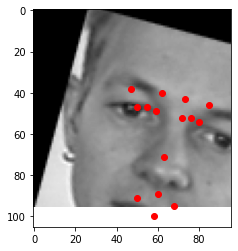

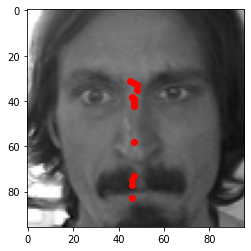

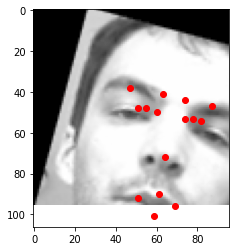

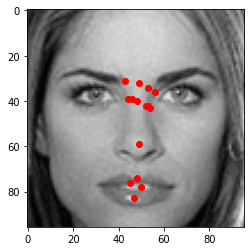

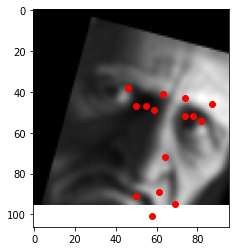

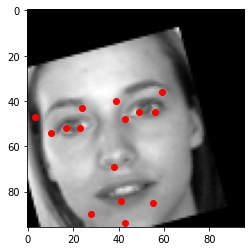

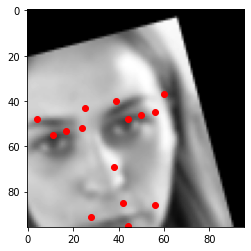

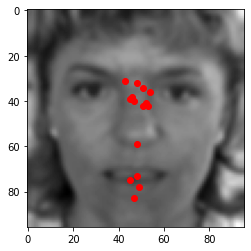

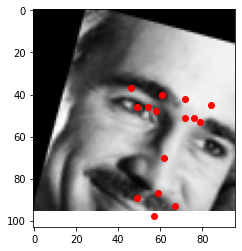

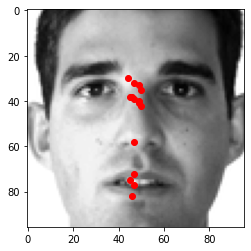

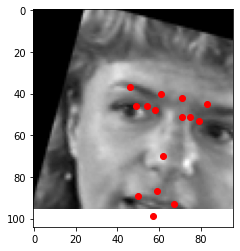

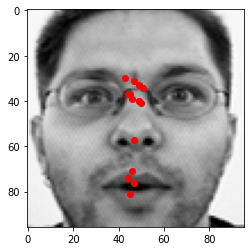

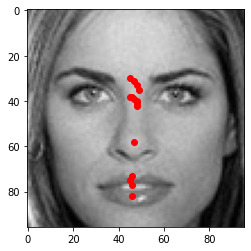

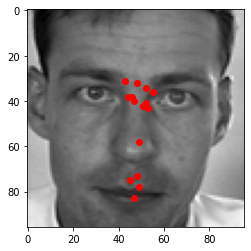

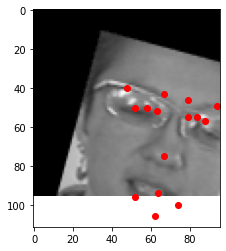

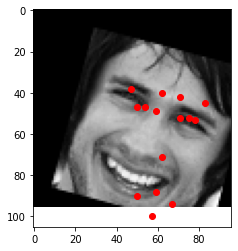

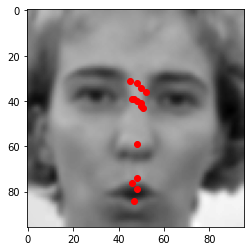

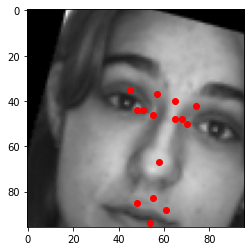

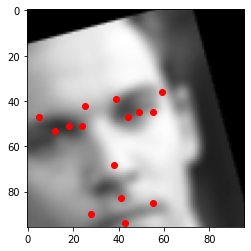

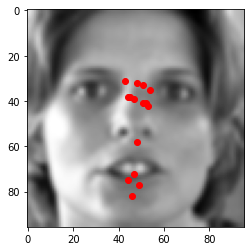

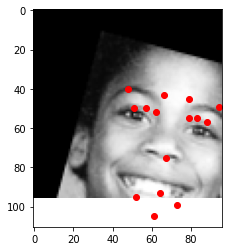

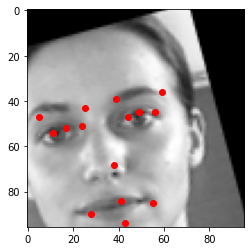

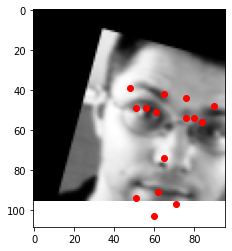

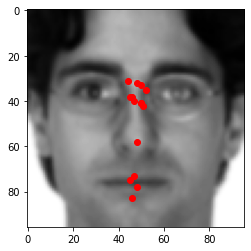

In [ ]:
predictions = np.int64(predictions)

random = np.random.randint(0, predictions.shape[0], size=24, dtype=int)

for i in range(len(random)):
  #image_with_kps(test_imgs[i], predictions[i])
  image_with_kps(X_val[i], predictions[i])

# Evaluation of the model

Once the selected architecture based model has been built and trained, it is time to get predictions for new cases, using the test images.

In [ ]:
test = pd.read_csv('test.csv')

In [ ]:
test_imgs = []
for i in range(len(test)):
  pixels = test["Image"][i].split(' ')
  img=np.reshape(np.array(pixels).flatten(), (96,96)).astype('int64')
  test_imgs.append(cv2.resize(img, (96,96)))

In [ ]:
if weights_path == 'net50.h5':
  predictions_norm = model.predict(X_val_rgb)

else:
  predictions_norm = model.predict(X_val)
  
predictions_norm.shape

107/107 [==============================] - 3s 27ms/step


(3424, 30)

In [ ]:
predictions = np.int64(predictions_norm*96)

random = np.random.randint(0, predictions.shape[0], size=24, dtype=int)

for i in range(len(random)):
  image_with_kps(X_val[i], predictions[i])

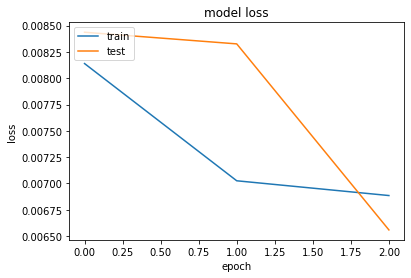

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Show figure
plt.show()